# Plot Examples

There are several built-in plot types that we can use to visualize the data.

## Inspect Input Photometry

First, we need to set up our target. As in the quickstart tutorial, we will use the M dwarf IRAS 04171+2756 from López-Valdivia et al. 2021 (DOI: [10.3847/1538-4357/ac1a7b](https://dx.doi.org/10.3847/1538-4357/ac1a7b)). 

In [1]:
from stelpar import Target, Estimate
target = Target('IRAS 04171+2756')
est = Estimate(target)

Before running the MCMC simulation with `est.run`, we can check the input photometry using `stelpar.plot.mag_v_wavelength_eyecheck` in case we would need to remove any bands.

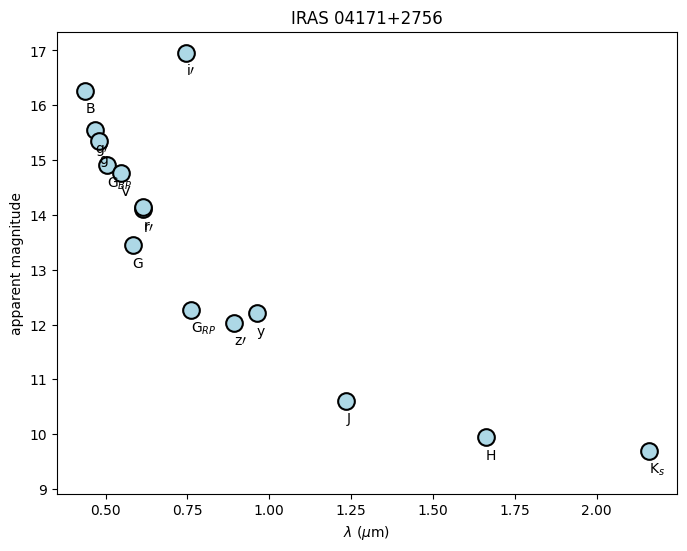

In [2]:
from stelpar.plot import mag_v_wavelength_eyecheck
mag_v_wavelength_eyecheck(est.photometry, name=target.name);

For reference, below are all possible labels for the individual points and their corresponding band. These can also be found in `stelpar.utils.phot_plot_labels`.

| Band (key) | label | Band (key) | label | Band (key) | label |
| ---- | :---: | ---- | :---: | ---- | :---: |
| 2mass_jmag | J | sdss_imag | i${\prime}$ | hipparcos_hpmag | H$_P$ |
| 2mass_hmag | H | sdss_zmag | z${\prime}$ | ps1_gmag | g |
| 2mass_kmag | K$_s$ | johnson_bmag | B | ps1_rmag | r |
| gaia_gmag | G | johnson_vmag | V | ps1_imag | i |
| gaia_bpmag | G$_{BP}$ | cousins_rmag | R | ps1_zmag | z |
| gaia_rpmag | G$_{RP}$ | cousins_imag | I | ps1_ymag | y |
| sdss_gmag | g${\prime}$ | tycho_bmag | B$_T$ | ps1_omag | o |
| sdss_rmag | r${\prime}$ | tycho_vmag | V$_T$ | ps1_wmag | w |

At the very least, it is easy to see that i$\prime$ is likely wrong (possible a measurement issue, wrong star, etc.), so we will remove it and plot again.

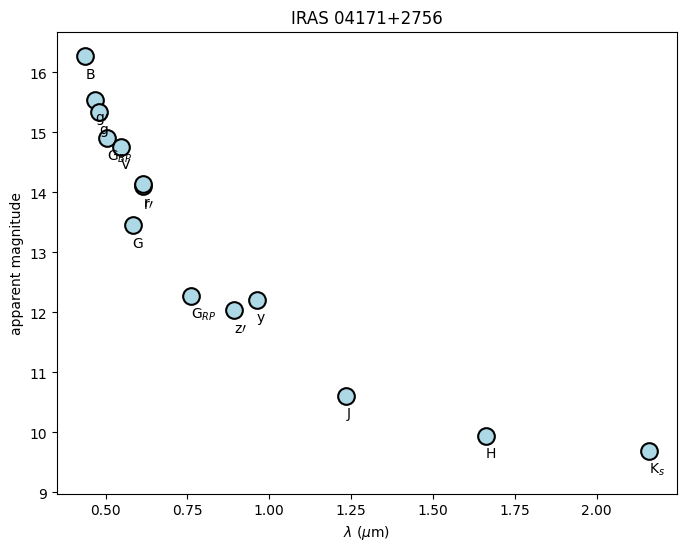

In [3]:
target.remove_photometry({
    'V/154/sdss16' : 'sdss_imag'
})
est = Estimate(target)
mag_v_wavelength_eyecheck(est.photometry, name=target.name);

Now that the problematic band(s) was removed, we can run the MCMC.

## Visualizing the Results

There are several plots that might be useful to analyze the results of the MCMC. First, we will run an MCMC that is longer than the quickstart example to have a more realistic result.

We can still save this to a backend for reproducibility later. We'll give it an upper bound on age since we know it is very young.

We could also change some of the options in our `Estimate` instance for increased speed.

`interp_method='nearest'` will use nearest-neighbor interpolation which is fastest. `zero_extinction=True` assumes interstellar extinction is zero which is useful for nearby, older stars. It is probably not true that extinction is actually zero (this is a pre-main-sequence star in Taurus-Auriga), so it is usually good practice to leave `zero_extinction=False` in most cases.

In [4]:
## set up the backend
import emcee
import numpy as np
filename = "tutorial_longer.h5"
backend = emcee.backends.HDFBackend(filename)

## set the upper bound of 50 Myr
## change position and perturbation to ensure the walkers initialize in this range
target.initial_conditions = dict(
    bounds=dict(
        age=(0, 50)
    ),
    position=dict(
        age=25
    ),
    perturbation=dict(
        age=20
    )
)

## assign walkers, steps, and initialize the estimator
nwalkers = 50
nsteps = 10000

est = Estimate(
    target,
    interp_method='nearest',
    zero_extinction=True
)

## run MCMC
sampler = est.run(nwalkers, nsteps, backend=backend)


loading isochrone model grid .

running MCMC for IRAS 04171+2756 (mag):


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<?, ?it/s]


Extract the useful results

In [5]:
posterior, photometry, chains = est.posterior(sampler, discard=5000, thin=25, max_prob=True)


extracting posterior for IRAS 04171+2756 (mag):

calculating max log probability:


100%|████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 88.55it/s]



getting other parameter chains:


100%|████████████████████████████████████████████████████████████████████| 10000/10000 [01:46<00:00, 93.73it/s]


### Flux vs. Wavelength

**Testing how well the fit performed**

The following is a two-panel figure that shows the median and maximum-likelihood (if available) fluxes compared to the observed fluxes in each band. The top shows flux vs. wavelength and the bottom shows a fractional residual in units of standard deviations ($\sigma$). As we can see, both the median and max-likelihood fall within 1$\sigma$ of the observations, and no band is more than 2$\sigma$ away from observations.

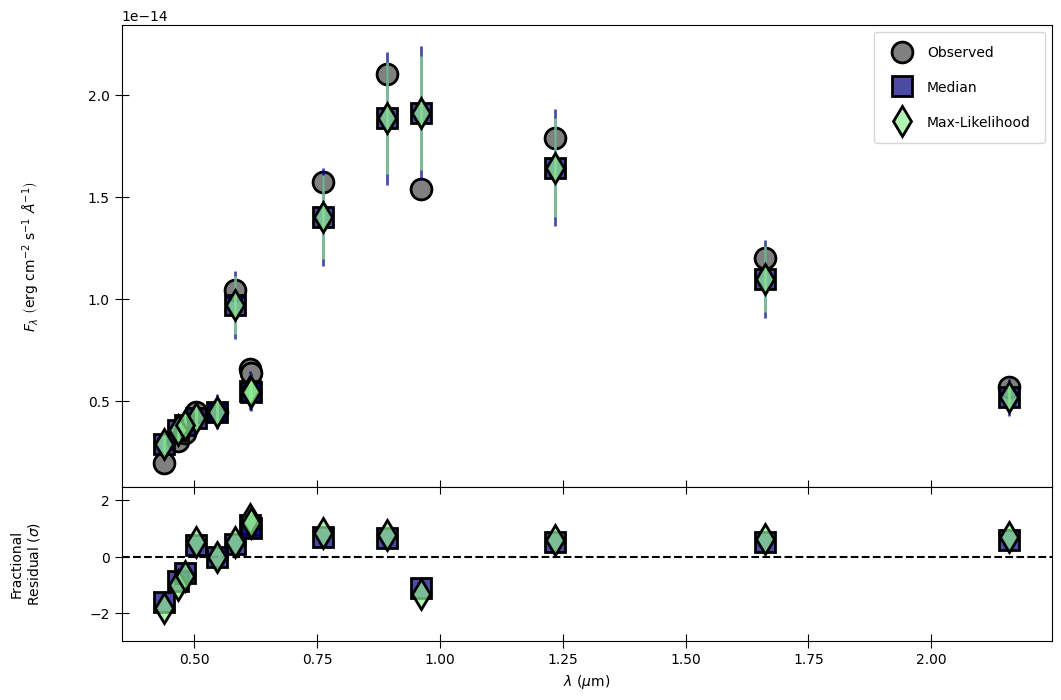

In [6]:
from stelpar.plot import flux_v_wavelength
flux_v_wavelength(photometry);

### Corner Plot

**Analyzing results for individual parameters and identifying relationships between parameters**

The following shows one-dimensional posterior probability distributions for each parameter (diagonal) and two-dimensional contours marking relationships between pairs of parameters (off-diagonal).

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The following plot (and this notebook overall) is meant to demonstrate visualization capability and should not be interpreted as a scientific result. These results do not include extinction which is likely necessary for this target.
</div>

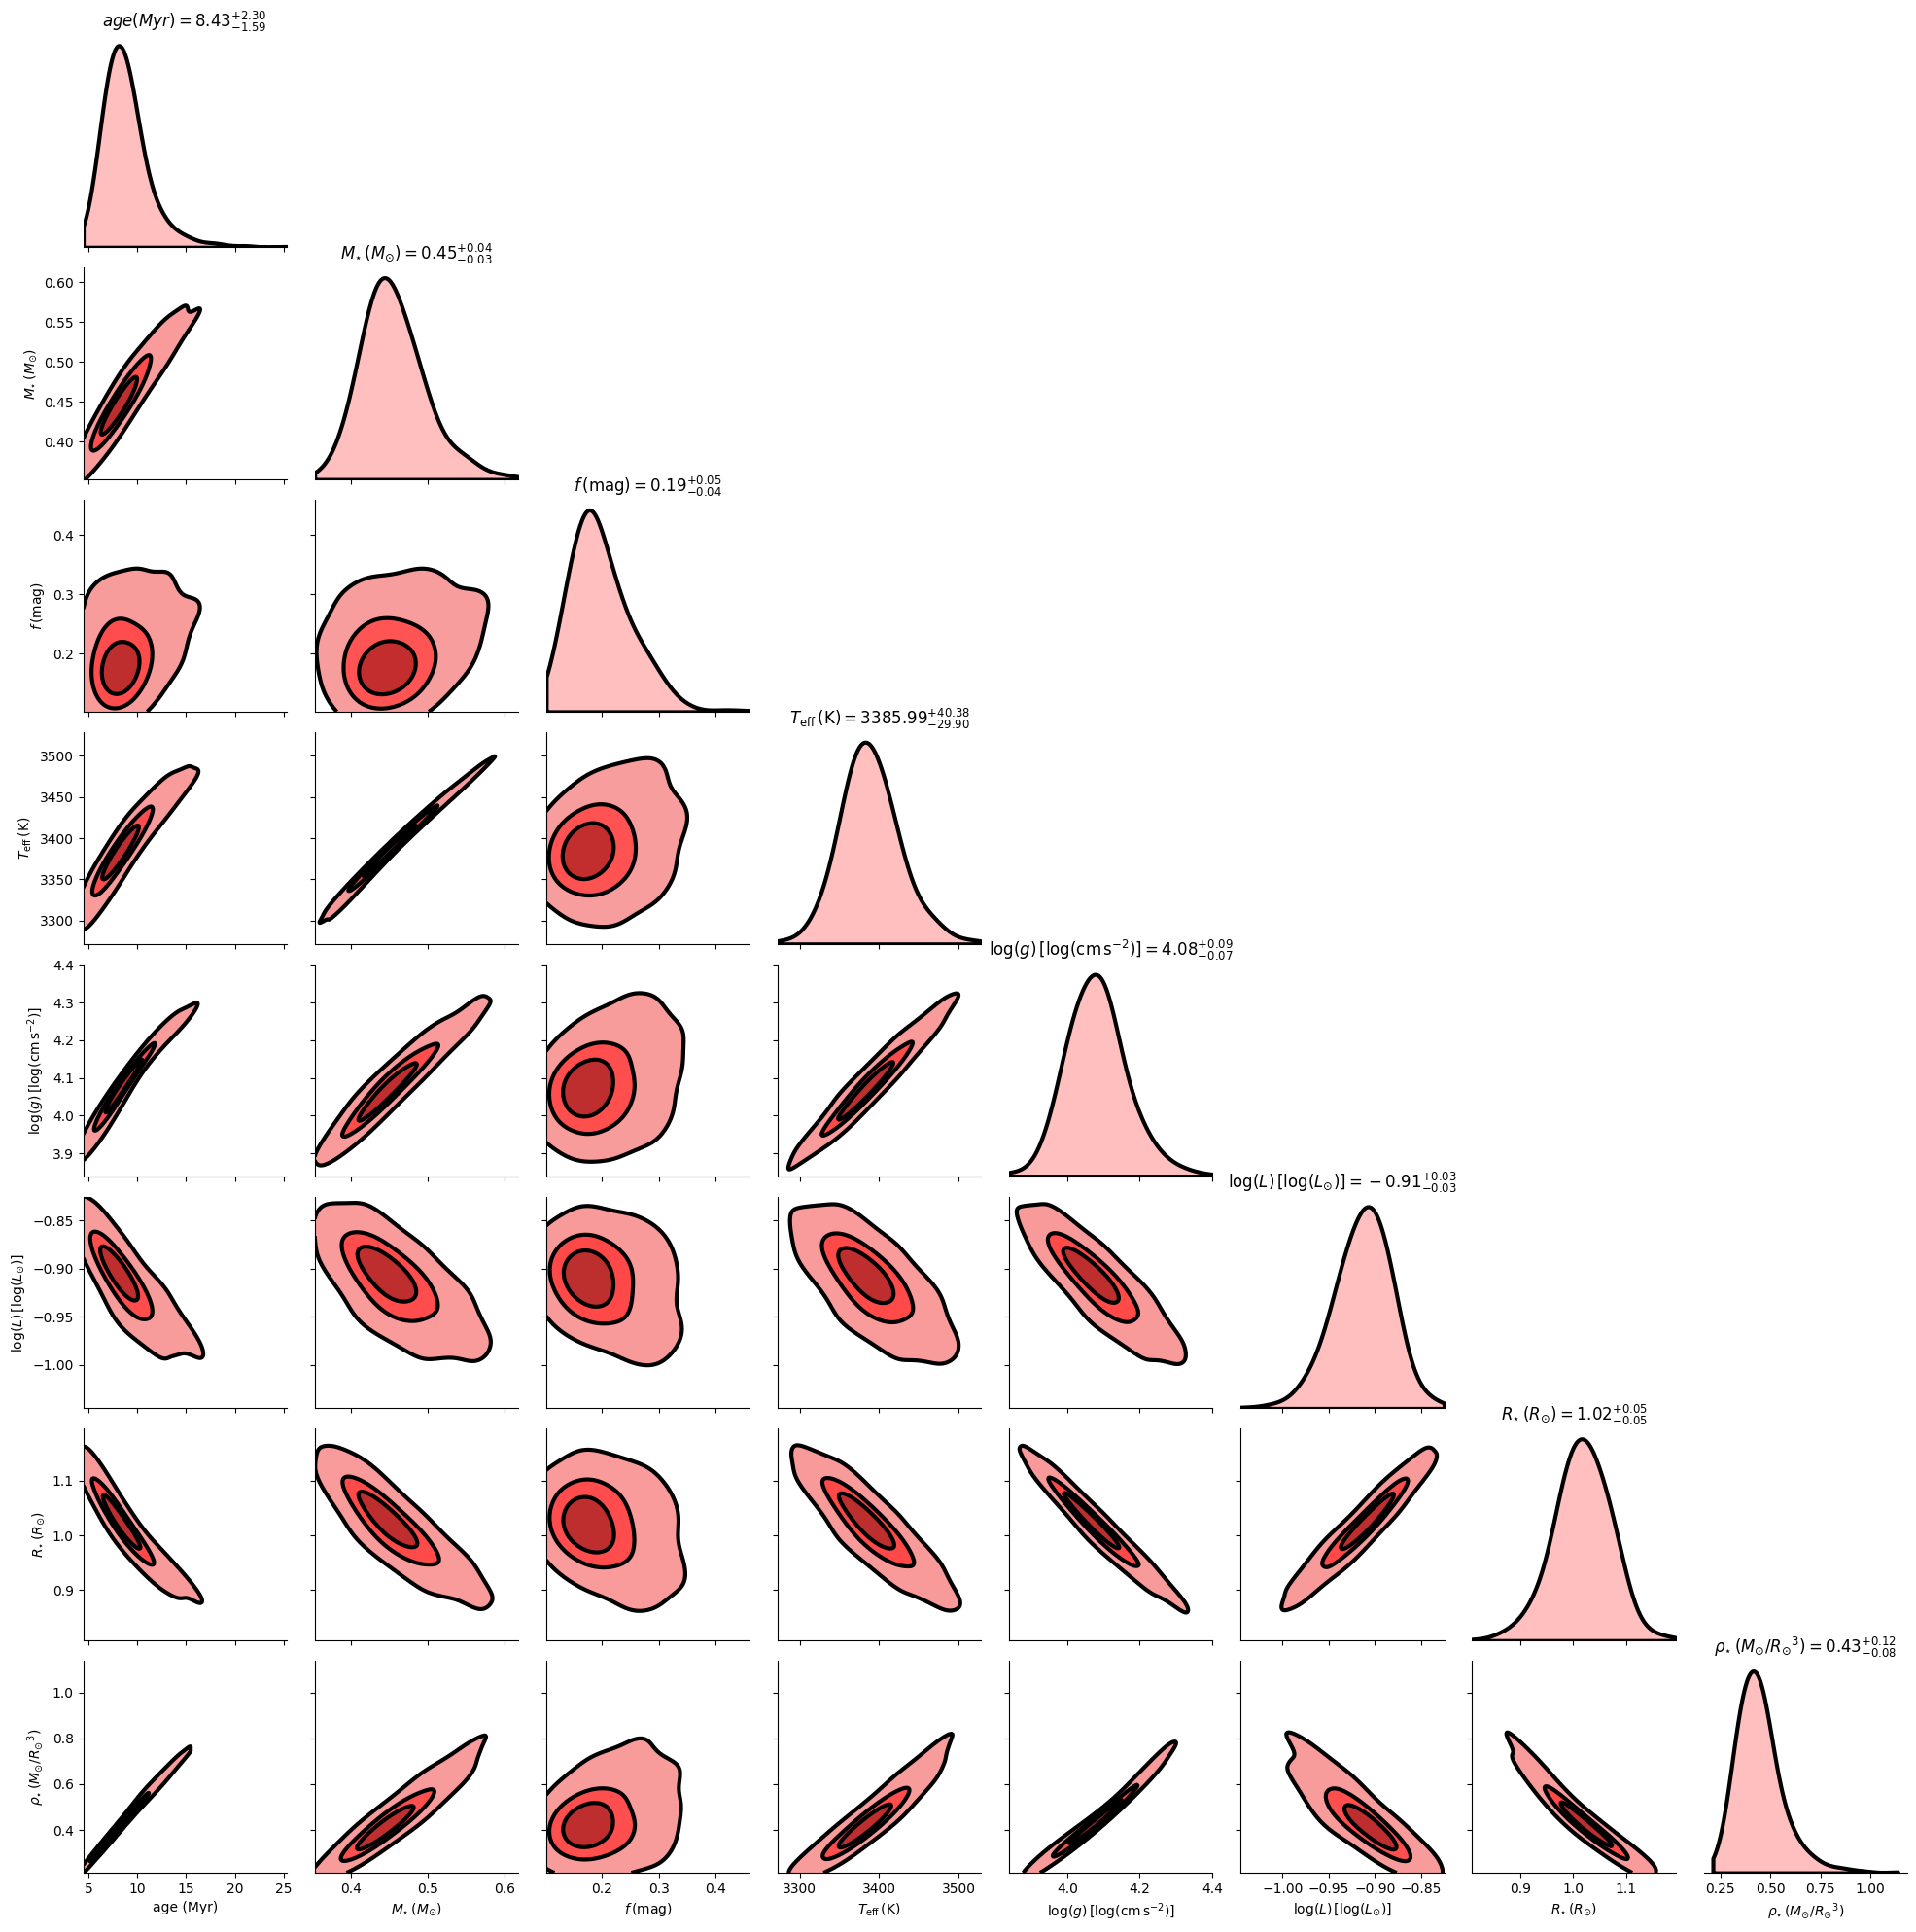

In [7]:
from stelpar.plot import corner_plot
corner_plot(
    chains,
    nsamples=500,
    show_titles=True,
    fill=True,
    fillcolor='red',
    edgecolor='black',
    bw_adjust=1.5,
);

### Time Series

**Viewing walker positions in parameter space over all steps**

Here, we are able to see when (if) the fit parameters converged and if they seem to be well-constrained. This is also a useful tool for selecting a discard or "burn-in" value when running `est.posterior`.

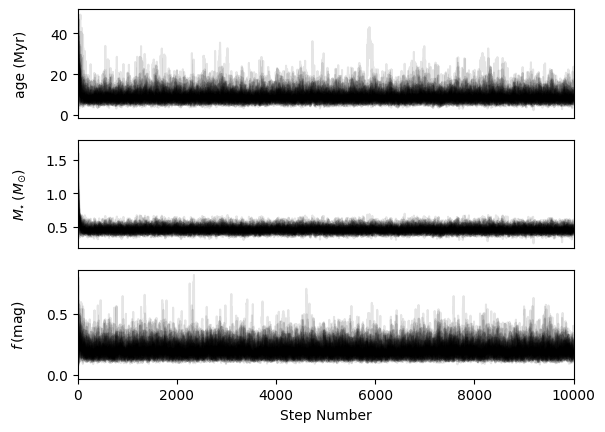

In [8]:
from stelpar.plot import time_series
time_series(sampler.get_chain(), alpha=0.1);